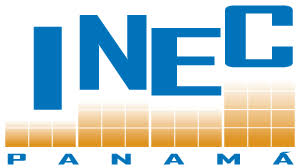

# Nowcast

Esta librería construye la estimación de nowcast usando la metodología especificada en el punto 2.2 (Factores dinámicos y regresión en dos etapas) del informe. Se busca obtener proyecciones trimestrales usando información mensual y que se pueda manejar el problema de datos faltantes sin tener que realizar proyecciones de variables adicionales.

Esta librería realiza la estimación y la evaluación, pero no la proyección.

# Librerías

Se importan las librerías necesarias para realizar el manejo de base de datos y/o proyección de los modelos.

- pykalman: Librería de filtro de kalman en python
- pandas: Manejo de bases de datos
- datetime: Manejo de fechas
- numpy: Manejo de matrices
- matploblib.pyplot: Gráficos
- os: Manejo de rutas
- seaborn: Gráficos adicionales
- ipynb.fs.defs.ConstruccionBasedeDatos: Función definida en el programa ConstruccionBasedeDatos para construir el insumo para hacer la estimación/proyección
- sklearn.metrics: Medidas de desempeño de la proyección
- sklearn.decomposition: Análisis de componentes principales

In [1]:
from pykalman import KalmanFilter
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos


import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

# Rutas para guardar inputs/outputs

In [2]:
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_nowcast/'


# Construcción de Base de datos

In [3]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Variables

In [4]:
#Frecuencia Trimestral

Z = ['pbif_Trimestre_VariacionAnual']

#Frecuencia Mensual (Para evaluación)

y = ['imae_Mensual_VariacionAnual']


#Frecuencia Mensual

#Modelo 1
'''
X =[
'ipc1_viv_Mensual_VariacionAnual',
'ipc1_Mensual_VariacionAnual',
'ipc1_trp_Mensual_VariacionAnual',
'imae_con_nrs_vl_Mensual_VariacionAnual',
'imae_com_exp_vl_Mensual_VariacionAnual',
'imae_man_con_Mensual_VariacionAnual',
'imae_trn_mct_Mensual_VariacionAnual',
'imae_trn_pea_pn_Mensual_VariacionAnual',
'imae_com_imp_vl_Mensual_VariacionAnual',
'imae_man_por_Mensual_VariacionAnual',
'finp_com_Mensual_VariacionAnual',
'finp_sss_otr_Mensual_VariacionAnual',
'fina_am1_dep_Mensual_VariacionAnual',
'finp_osd_nrs_Mensual_VariacionAnual',
'finp_osd_Mensual_VariacionAnual',
'finp_osd_vig_Mensual_VariacionAnual',
'fini_com_Mensual_VariacionAnual'
]
'''
#Modelo 2 - Sin series financieras

'''
X =[
'ipc1_viv_Mensual_VariacionAnual',
'ipc1_Mensual_VariacionAnual',
'ipc1_trp_Mensual_VariacionAnual',
'imae_con_nrs_vl_Mensual_VariacionAnual',
'imae_com_exp_vl_Mensual_VariacionAnual',
'imae_man_con_Mensual_VariacionAnual',
'imae_trn_mct_Mensual_VariacionAnual',
'imae_trn_pea_pn_Mensual_VariacionAnual',
'imae_com_imp_vl_Mensual_VariacionAnual',
'imae_man_por_Mensual_VariacionAnual',
]
'''

#Modelo 3 - Solo series de precios


'''
X =[
'ipc1_viv_Mensual_VariacionAnual',
'ipc1_Mensual_VariacionAnual',
'ipc1_trp_Mensual_VariacionAnual',
]
'''



#Modelo 4 - Solo series de actividad
'''
X =[
'imae_con_nrs_vl_Mensual_VariacionAnual',
'imae_com_exp_vl_Mensual_VariacionAnual',
'imae_man_con_Mensual_VariacionAnual',
'imae_trn_mct_Mensual_VariacionAnual',
'imae_trn_pea_pn_Mensual_VariacionAnual',
'imae_com_imp_vl_Mensual_VariacionAnual',
'imae_man_por_Mensual_VariacionAnual',
]
'''

#Modelo 5 - Máxima prediccion


# Primera etapa - Información mensual

La estimación de esta primera etapa dell modelo se realiza usando un filtro de kalman y componentes principales, para reducir la información de las variables en un indicador estable.

#####  Filtro de Kalman - Nowcast

Este método se basa en Stock y Watson (1989). Se asume que la información disponible al periodo t se encuentra generada por factores subyacentes:

$$X_t=\lambda F_t+η_t$$

Donde:

$X_t$: Variables disponibles
$F_t$: Factor subyacente
$η_t$: Error

###### __kalman_fed_nyc__

La función __kalman_fed_nyc__ realiza la extracción del factor común $F_t$ usado en la segunda etapa de la proyección mensual, para ello usa los siguientes insumos:

- __bd_all__: Base de datos que contiene la infomación de variables.
- __X__: Variables X_t de las cuales no se desea proyección mensual.
- __y__: Variables X_t de las cuales se desea proyección mensual.
- __n_factors__: Número de factores comunes de la data.
- __initial_state_mean__ : Media inicial de las no observables.
- __initial_state_covariance__: Varianza inicial de las no observables.
- __test_size__: Observaciones dejadas para realizar el test.

###### Otras funciones

La función __t_params__ y __t_inv_param__ se usan para estimar parámetros estables del modelo.

La función __set_init_params__ estima los parámetros del modelo usando un análisis de componentes principales y regresiones de los errores.


In [5]:
def kalman_fed_nyc(bd_all, X, y, n_factors, params,initial_state_mean,initial_state_covariance, test_size):

    n_vars = len(y + X)
    
    ##############################################################################
    #Data
    
    bd = bd_all[y + X]
    size_drop = int(bd.shape[0]/3)
    
    bd = bd.drop(bd.index[
                        (bd.index < bd.index[size_drop]) * 
                        (bd.isna().any(axis = 1).values)
                        ])
    
    #Fijando base de referencia  en caso se haga un ejercicio de train test
    bd_data = bd[y]
    
    
    #No se recibe informacion test_size periodos
    if test_size>0:
        bd.loc[-test_size:,y] = np.nan
    
    ###############################################################################
    #Demean data

    mean = bd.mean()
    
    bd_demean = pd.DataFrame()
    
    for i in bd.columns:
        bd_demean[i] =  bd[i] - mean[i]
        

    ################################################################################
    #Llenando data faltante

    bd_demean = bd_demean.fillna(0)

    #Parametros
    phi   = params[0]
    var_m = params[1]
    rho   = params[2]
    var_e = params[3]
    beta  = params[4]

    ###############################################
    #Matriz de observables

    H = []

    for date in bd_demean.index:
        aux = np.zeros([n_vars,n_factors+n_vars])
        i_aux = np.eye(n_vars)
        for i_var,var in enumerate(bd_demean.columns):
            if (bd_demean.loc[date,var] != 0):
                aux[i_var,:] = np.array(list(beta[i_var,:]) + list(i_aux[i_var,:]))
        H.append(aux)



    observation_offset = [0] * n_vars
    observation_matrix = np.array(H)
    observation_covariance =  np.zeros([n_vars,n_vars])

    H_ = np.zeros([n_vars,n_factors+n_vars])
    H_[:,:n_factors] = beta
    H_[:,n_factors:] = np.eye(n_vars)
    
    ###############################################
    #Transicion

    #Interceptos
    transition_offset = [0] * (n_factors + n_vars)

    #Matriz de transicion
    transition_matrix = np.zeros([n_factors + n_vars,n_factors + n_vars])
    transition_matrix[:n_factors,:n_factors] = np.diag(phi)
    transition_matrix[n_factors:,n_factors:] = np.diag(rho)

    #Varianzas 

    transition_covariance = np.zeros([n_factors + n_vars,n_factors + n_vars])
    transition_covariance[:n_factors,:n_factors] = np.diag(var_m)
    transition_covariance[n_factors:,n_factors:] = np.diag(var_e)

    ###############################################
    #Estados iniciales
    initial_state_mean = np.zeros([n_factors + n_vars])
    initial_state_covariance = np.eye(n_factors + n_vars) * 0.01**2

    # Creando filtro
    kf = KalmanFilter(
        transition_matrix, observation_matrix, 
        transition_covariance, observation_covariance,
        transition_offset,observation_offset,
        initial_state_mean, initial_state_covariance
        ,random_state=1109
    )

    ll = kf.loglikelihood(bd_demean)

    bd_S = pd.DataFrame(kf.smooth(bd_demean[y + X])[0], index = bd_demean.index).rename(columns = lambda y: 'NoObservale_Suavizada_' + str(y))
    bd_F = pd.DataFrame(kf.filter(bd_demean[y + X])[0], index = bd_demean.index).rename(columns = lambda y: 'NoObservale_Filtrada_' + str(y))
    bd_P = pd.DataFrame(kf.filter(bd_demean[y + X])[0] @ np.transpose(H_),index = bd_demean.index, columns = bd_demean.columns)
    
    
    for i in bd_P.columns:
        bd_P[i] = bd_P + mean[i]
    
    
    return ll, kf, bd_S, bd_F, bd_P, bd, bd_data


def t_params(h_params,n_vars,n_factors):
    
    phi = []
    for x in h_params[0:n_factors]:
        phi.append(x/(1+abs(x)))
    
    var_m = []
    for x in h_params[n_factors:2*n_factors]:
        var_m.append(x**2)
    
    
    rho = []
    for x in h_params[2*n_factors:2*n_factors+n_vars]:
        rho.append(x/(1+abs(x)))
    
    
    var_e = []
    for x in h_params[2*n_factors+n_vars:2*n_factors+2*n_vars]:
        var_e.append(x**2)
    
    
    beta = np.array(h_params[2*n_factors+2*n_vars:]).reshape(n_vars,n_factors)
    
    params = [phi,var_m,rho,var_e,beta]
    
    return params

def t_inv_param(params):
    phi = params[0]
    var_m = params[1]
    rho = params[2]
    var_e = params[3]
    beta = params[4]
    
    
    h_params = []
    
    for x in phi:
        h_params.append(x/(1-x))
    
    
    for x in var_m:
        h_params.append(x**0.5)
    
    
    for x in rho:
        h_params.append(x/(1-x))
    
    
    for x in var_e:
        h_params.append(x**0.5)
    
    
    
    h_params = h_params + list(beta.flat[:])

    return h_params

def set_init_params(bd_all, X, y, n_factors,test_size):
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression

    n_vars = len(y + X)
    
    
    bd = bd_all[y + X]
    bd = bd.dropna()
    
    #############################################################
    #Componentes Principales
    #############################################################
    
    PCA_IC = PCA(n_components=n_factors)
    lin_reg = LinearRegression(fit_intercept = False)
    
    PC_IC = PCA_IC.fit_transform(bd)
    
    
    #Beta
    beta_ic = np.transpose(PCA_IC.components_)

    
    #Phi y sigma_m
    phi_ic = []
    var_m_ic = []


    for j in range(n_factors):

        lin_reg.fit(PC_IC[:-1,j].reshape(-1,1),PC_IC[1:,j].reshape(-1,1))
        phi_ic.append(lin_reg.coef_[0,0])
        var_m_ic.append(np.var(PC_IC[:,j])*(1-lin_reg.coef_[0,0]**2))

    
    #Errores de prediccion
    
    rho_ic = []
    var_e_ic = []
    
    error = bd.values - PCA_IC.inverse_transform(PC_IC)
    
    for j in range(n_vars):
        lin_reg.fit(error[:-1,j].reshape(-1,1),error[1:,j].reshape(-1,1))
        rho_ic.append(lin_reg.coef_[0,0])
        var_e_ic.append(np.var(error[:-1,j])*(1-lin_reg.coef_[0,0]**2))
    
    
    initial_state_mean = PC_IC[0,:]
    initial_state_covariance = np.diag(np.var(PC_IC,axis=0))
    
    params_ic = [phi_ic,var_m_ic,rho_ic,var_e_ic,beta_ic]
        
    h_params_ic =t_inv_param(params_ic)
    
    return params_ic, h_params_ic, initial_state_mean, initial_state_covariance

##### Definiendo número de factores, numero de variables y muestra para test

In [6]:
test_size = 0
n_factors= 1
n_vars = len(X+y)


##### Componentes principales - Exploratorio

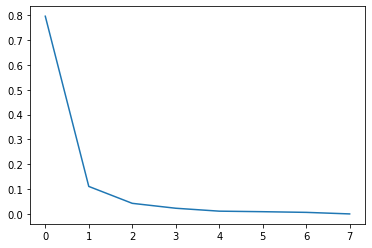

In [7]:
PCA_ = PCA(n_components=bd_all[y + X].shape[1])
PCA_.fit(bd_all[y+X].dropna())
plt.plot(PCA_.explained_variance_ratio_)

##### Parámetros iniciales

In [8]:
params_ic, h_params_ic_pc, initial_state_mean, initial_state_covariance= set_init_params(bd_all, X, y, n_factors,test_size)

##### Nowcast inicial

In [9]:
ll, kf, bd_S,bd_F, bd_P, bd,bd_data = kalman_fed_nyc(bd_all,X,y,n_factors,params_ic,
                                             initial_state_mean,initial_state_covariance,test_size)


##### Resultados - Proyección mensual

In [10]:
bd_data.join(bd_P[y].rename(columns = lambda y: 'PRED_' + y))[-12:]

,imae_Mensual_VariacionAnual,PRED_imae_Mensual_VariacionAnual
per,,
2019-07-01,0.036311,0.036311
2019-08-01,0.031975,0.031975
2019-09-01,0.039755,0.039755
2019-10-01,0.033907,0.033907
2019-11-01,0.036137,0.036137
2019-12-01,NaN,0.044637
2020-01-01,NaN,0.051628
2020-02-01,NaN,0.055546
2020-03-01,NaN,0.058146


##### Estimación - Máxima verosimilitud

Esta estimación se realiza para afinar las estimaciones iniciales. No es necesaria la convergencia.

In [11]:
from numdifftools import Jacobian, Hessian
from scipy.optimize import minimize


z_min = lambda params: -kalman_fed_nyc(bd_all,X,y,n_factors,t_params(params,len(X+y),n_factors),
                                       initial_state_mean,initial_state_covariance,test_size)[0]
z_hess = lambda params: -kalman_fed_nyc(bd_all,X,y,n_factors,params,
                                        initial_state_mean,initial_state_covariance,test_size)[0]

x0 = h_params_ic_pc
x_opt_ = minimize(z_min, x0, method='Nelder-Mead', options={'disp': True,'maxiter':10})


In [12]:
ll, kf, bd_S,bd_F, bd_P, bd, bd_data = kalman_fed_nyc(bd_all,X,y,n_factors,t_params(x_opt_.x,len(X+y),n_factors),
                                             initial_state_mean,initial_state_covariance,0)

##### Guardando el modelo como una lista

In [13]:
Nowcast_model = [X,y,n_factors,t_params(x_opt_.x,len(X+y),n_factors),initial_state_mean,initial_state_covariance, bd, bd_data]

import pickle

with open(rutaModelos + 'nowcast_model.pkl', 'wb') as f:
    pickle.dump(Nowcast_model, f)

##### Proyecciones mensuales

In [14]:
bd_data.join(bd_P[y].rename(columns = lambda y: 'PRED_' + y))

,imae_Mensual_VariacionAnual,PRED_imae_Mensual_VariacionAnual
per,,
2004-01-01,0.061897,0.061897
2004-02-01,0.049983,0.049983
2004-03-01,0.113209,0.113209
2004-04-01,0.083952,0.083952
2004-05-01,0.048694,0.048694
...,...,...
2020-02-01,NaN,0.055537
2020-03-01,NaN,0.058140
2020-04-01,NaN,0.059867


# Segunda etapa - Proyecciones trimestrales 

Se estima una segunda etapa, donde el PIB ($y_t$) depende del factor $F_t$ obtenido de la primera etapa:

$$y_t= \gamma + \kappa F_t+\epsilon_t$$

##### Estimación de la segunda etapa del modelo

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pickle

Linear_ = LinearRegression()

bd_2etapa = bd_S[bd_S.columns[0]].groupby(pd.Grouper(freq = 'Q')).aggregate([lambda y: y[0], lambda y: y[1] if len(y)>1 else np.nan, lambda y: y[2] if len(y)>2 else np.nan]).rename(columns = lambda y: y[8])
X_ = bd_2etapa.columns
bd_2etapa = bd_2etapa.join(bd_all[Z].groupby(pd.Grouper(freq = 'Q')).sum())
bd_2etapa[bd_2etapa[Z] == 0 ] = np.nan
bd_2etapa = bd_2etapa.dropna()


bd_train, bd_test, y_train, y_test = train_test_split(bd_2etapa[X_],bd_2etapa[Z], random_state = 1109)

#Fit de modelos lineales

Linear_.fit(bd_2etapa[X_],bd_2etapa[Z])

#Guardando modelos

with open(rutaModelos + 'nowcast_2stage.pkl', 'wb') as f:
    pickle.dump([Z,Linear_], f)

##### Evaluacion de proyecciones trimestrales

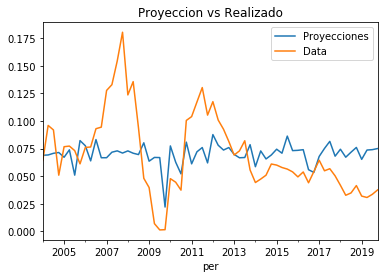

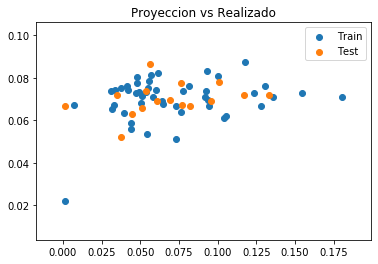

'R2 insample:0.0664453761715057'

'R2 outsample:0.08563525806562633'

In [16]:
bd_evaluacion = pd.DataFrame(Linear_.predict(bd_train), index = bd_train.index).append(pd.DataFrame(Linear_.predict(bd_test), index = bd_test.index)).sort_index()
bd_evaluacion = bd_evaluacion.rename(columns = lambda y: 'Proyecciones')
bd_evaluacion['Data'] = bd_2etapa[Z]

bd_evaluacion.plot()
plt.title('Proyeccion vs Realizado')
plt.show()


plt.scatter(y_train, Linear_.predict(bd_train))
plt.scatter(y_test, Linear_.predict(bd_test))
plt.legend(['Train','Test'])
plt.title('Proyeccion vs Realizado')
plt.show()

#Scores outsamples

display("R2 insample:" + str(Linear_.score(bd_train,y_train)))
display("R2 outsample:" + str(Linear_.score(bd_test,y_test)))

In [17]:
with pd.ExcelWriter(rutaDestino + 'evalNowcast.xlsx') as writer:
    bd_evaluacion.to_excel(writer, sheet_name='Proyecciones Nowcast')